In [1]:
# addprocs(CPU_CORES)  # Not Necessarily a good idea to use all due to memory issues

@everywhere begin
  using StochasticDiffEq, DiffEqBase, DiffEqProblemLibrary,
        DiffEqMonteCarlo, Plots, LaTeXStrings, ParallelDataTransfer

  probs = Vector{SDETestProblem}(3)
  p1 = Vector{Any}(3)
  p2 = Vector{Any}(3)
  p3 = Vector{Any}(3)
  ## Problem 1
  probs[1] = prob_sde_linear
  ## Problem 2
  probs[2] = prob_sde_wave
  ## Problem 3
  probs[3] = prob_sde_additive
end

fullMeans = Vector{Array}(3)
fullMedians = Vector{Array}(3)
fullElapsed = Vector{Array}(3)
fullTols = Vector{Array}(3)

titleFontSize = 24
guideFontSize = 18
legendFontSize= 14
tickFontSize  = 16
Ns = [17 23 17]

  likely near In[1]:1
, Any, Any) in module StochasticDiffEq at /home/crackauc/.julia/v0.5/StochasticDiffEq/src/solve.jl:25 overwritten in module StochasticDiffEq at /home/crackauc/.julia/v0.5/StochasticDiffEq/src/solve.jl:25.
{Any, 1}, DiffEqBase.#solve, DiffEqBase.AbstractSDEProblem{#uType<:Any, #tType<:Any, #isinplace<:Any, #NoiseClass<:Any, #F<:Any, #F2<:Any, #F3<:Any}, #algType<:DiffEqBase.AbstractSDEAlgorithm, Any, Any, Any) in module StochasticDiffEq overwritten in module StochasticDiffEq.
Any, #NoiseClass<:Any, #F<:Any, #F2<:Any, #F3<:Any}, #algType<:DiffEqBase.AbstractSDEAlgorithm, Any) in module StochasticDiffEq at /home/crackauc/.julia/v0.5/StochasticDiffEq/src/solve.jl:25 overwritten in module StochasticDiffEq at /home/crackauc/.julia/v0.5/StochasticDiffEq/src/solve.jl:25.
#uType<:Any, #tType<:Any, WARNING: Method definition #isinplace<:#solveAny(, Array#NoiseClass<:{Any, Any#F<:, Any1, }#F2<:, AnyDiffEqBase, .#F3<:#solveAny, }DiffEqBase, .#algType<:AbstractSDEProblemDiffEq

1×3 Array{Int64,2}:
 17  23  17

Timings are only valid if no workers die. Workers die if you run out of memory. This computer is high in computing resources but caps the memory at 126G, lower than the one used originally. Will have to be re-run sometime.

In [2]:
for k in eachindex(probs)
  println("Problem $k")
  ## Setup
  N = Ns[k]
  prob = probs[k]
  ParallelDataTransfer.sendto(workers(), prob=prob)

  msims = Vector{AbstractMonteCarloSimulation}(N)
  elapsed = Array{Float64}(N,3)
  medians = Array{Float64}(N,3)
  means   = Array{Float64}(N,3)
  tols    = Array{Float64}(N,3)

  #Compile
  adaptivealg=:RSwM1
  monte_carlo_simulation(prob,SRIW1(),dt=1/2^(4),adaptive=true,numMonte=1000,abstol=2.0^(-1),reltol=0,adaptivealg=adaptivealg)

  println("RSwM1")
  adaptivealg=:RSwM1
  for i=1:N
    tols[i,1] = 2.0^(-i-1)
    msims[i] = calculate_sim_errors(monte_carlo_simulation(prob,SRIW1(),dt=1/2^(4),
                                    adaptive=true,numMonte=1000,abstol=2.0^(-i-1),
                                    reltol=0,adaptivealg=adaptivealg))
    elapsed[i,1] = msims[i].elapsedTime
    medians[i,1] = msims[i].error_medians[:final]
    means[i,1]   = msims[i].error_means[:final]
  end

  println("RSwM2")
  adaptivealg=:RSwM2
  for i=1:N
    tols[i,2] = 2.0^(-i-1)
    msims[i] = calculate_sim_errors(monte_carlo_simulation(prob,SRIW1(),dt=1/2^(4),
                                    adaptive=true,numMonte=1000,abstol=2.0^(-i-1),
                                    reltol=0,adaptivealg=adaptivealg))
    elapsed[i,2] = msims[i].elapsedTime
    medians[i,2] = msims[i].error_medians[:final]
    means[i,2]   = msims[i].error_means[:final]
  end

  println("RSwM3")
  adaptivealg=:RSwM3
  for i=1:N
    tols[i,3] = 2.0^(-i-1)
    msims[i] = calculate_sim_errors(monte_carlo_simulation(prob,SRIW1(),dt=1/2^(4),
                                    adaptive=true,numMonte=1000,abstol=2.0^(-i-1),
                                    reltol=0,adaptivealg=adaptivealg))
    elapsed[i,3] = msims[i].elapsedTime
    medians[i,3] = msims[i].error_medians[:final]
    means[i,3]   = msims[i].error_means[:final]
  end

  fullMeans[k] = means
  fullMedians[k] =medians
  fullElapsed[k] = elapsed
  fullTols[k] = tols
end


Problem 1
RSwM1
RSwM2


Worker 5 terminated.


RSwM3


ERROR (unhandled task failure): EOFError: read end of file
Worker 2 terminated.
ERROR (unhandled task failure): EOFError: read end of file


Problem 2
RSwM1
RSwM2
RSwM3
Problem 3
RSwM1
RSwM2
RSwM3


In [3]:
lw=3
leg=String["RSwM1","RSwM2","RSwM3"]'

for k in eachindex(probs)
  p1[k] = plot(fullTols[k],fullMeans[k],xscale=:log10,yscale=:log10,  xguide="Absolute Tolerance",yguide="Mean Final Error",title="Example $k"  ,linewidth=lw,grid=false,lab=leg,top_margin=50px,left_margin=100px,right_margin=50px,bottom_margin=50px,titlefont=font(titleFontSize),legendfont=font(legendFontSize),tickfont=font(tickFontSize),guidefont=font(guideFontSize))
  p2[k] = plot(fullTols[k],fullMedians[k],xscale=:log10,yscale=:log10,xguide="Absolute Tolerance",yguide="Median Final Error",title="Example $k",linewidth=lw,grid=false,lab=leg,top_margin=50px,left_margin=100px,right_margin=50px,bottom_margin=50px,titlefont=font(titleFontSize),legendfont=font(legendFontSize),tickfont=font(tickFontSize),guidefont=font(guideFontSize))
  p3[k] = plot(fullTols[k],fullElapsed[k],xscale=:log10,yscale=:log10,xguide="Absolute Tolerance",yguide="Elapsed Time",title="Example $k"      ,linewidth=lw,grid=false,lab=leg,top_margin=50px,left_margin=100px,right_margin=50px,bottom_margin=50px,titlefont=font(titleFontSize),legendfont=font(legendFontSize),tickfont=font(tickFontSize),guidefont=font(guideFontSize))
end

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in transpose(::String) at ./deprecated.jl:770
 in ctranspose at ./operators.jl:315 [inlined]
 in (::Base.##209#210)(::Tuple{Int64,String}) at ./<missing>:0
 in copy!(::Array{String,2}, ::Base.Generator{Base.Prod2{Base.OneTo{Int64},Array{String,1}},Base.##209#210}) at ./abstractarray.jl:477
 in _collect(::Type{String}, ::Base.Generator{Base.Prod2{Base.OneTo{Int64},Array{String,1}},Base.##209#210}, ::Base.HasShape) at ./array.jl:251
 in ctranspose(::Array{String,1}) at ./arraymath.jl:417
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/crackauc/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /home/crackauc/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[3], in expression starting on line 2



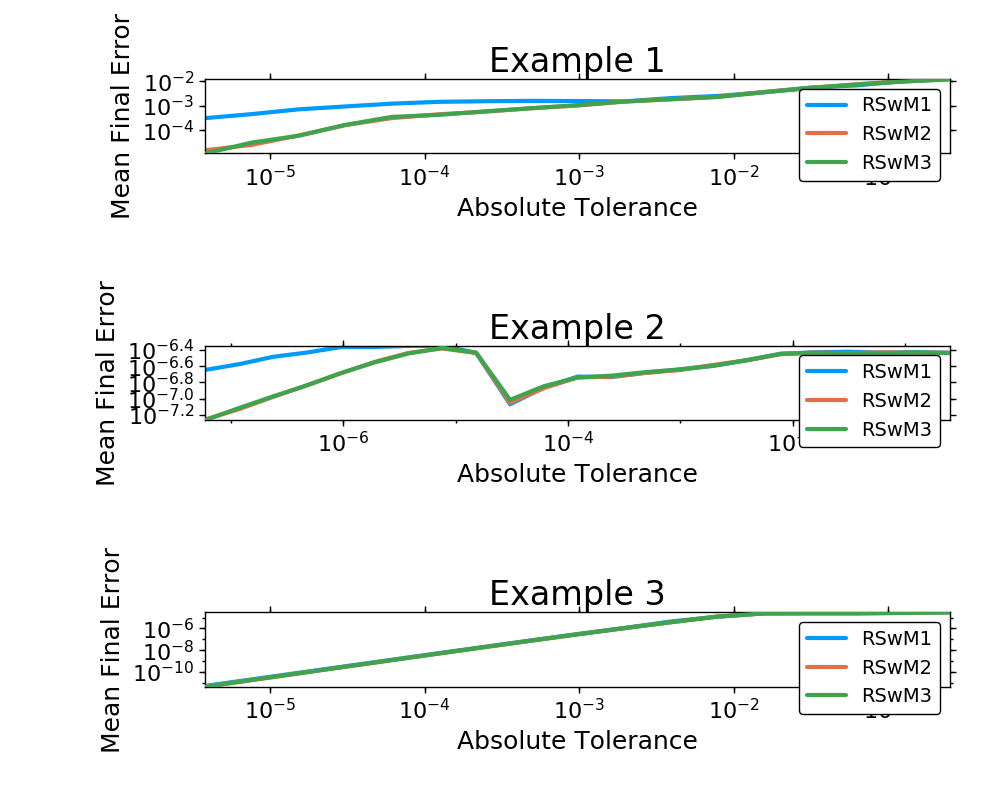

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [4]:
plot!(p1[1],margin=[20mm 0mm])
plot(p1[1],p1[2],p1[3],layout=(3,1),size=(1000,800),top_margin=50px,left_margin=100px,right_margin=50px)
#savefig("meanvstol.png")
#savefig("meanvstol.pdf")

In [5]:
plot(p3[1],p3[2],p3[3],layout=(3,1),size=(1000,800),top_margin=50px,left_margin=100px,right_margin=50px)
#savefig("timevstol.png")
#savefig("timevstol.pdf")


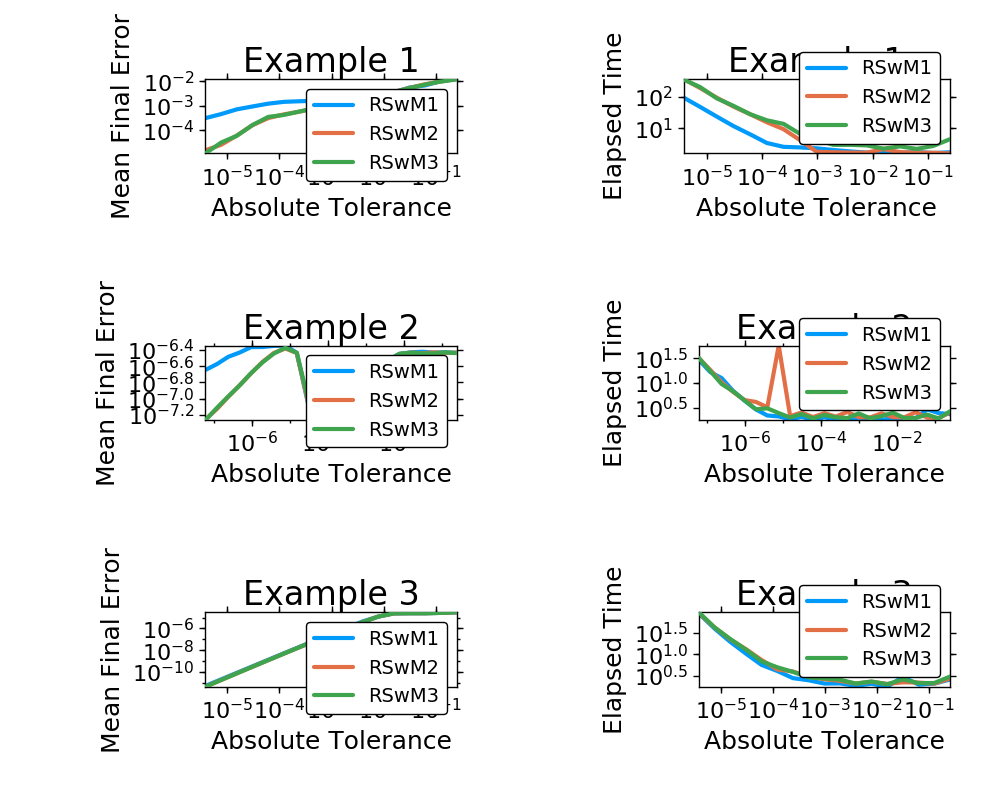

Worker 8 terminated.
ERROR (unhandled task failure): EOFError: read end of file


In [6]:
plot(p1[1],p3[1],p1[2],p3[2],p1[3],p3[3],layout=(3,2),size=(1000,800),top_margin=50px,left_margin=100px,right_margin=50px)